# Projet 10 : Détectez des faux billets 

# 1. Importer les données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import plotly.express as px


from sklearn.cluster import KMeans
import os, warnings
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Import des données

billets = pd.read_csv('billets.csv', delimiter= ';')
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [3]:
# On voit qu'on a 7 variables et 1500 lignes

billets.shape

(1500, 7)

In [4]:
# Analyse rapide des dimensions des billets: on voit qu'on est sur des ordres similaires.

billets.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

In [5]:
# Analyse de la variable "is_genuine"

billets.is_genuine.unique()

# Il n'y a que deux possibilités: Vrai ou Faux

array([ True, False])

In [6]:
# Il y a 1000 billets "Vrais" (sauf pour la variable "margin_low")
 
billets.loc[billets['is_genuine'] == True].count()

is_genuine      1000
diagonal        1000
height_left     1000
height_right    1000
margin_low       971
margin_up       1000
length          1000
dtype: int64

In [7]:
# Il y a 500 billets "Faux" (sauf pour la variable "margin_low")

billets.loc[billets['is_genuine'] == False].count()

is_genuine      500
diagonal        500
height_left     500
height_right    500
margin_low      492
margin_up       500
length          500
dtype: int64

In [8]:
# Il manque des infos pour la variable "margin_low", nous en avions connaissance dans la mission

billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [9]:
# On va devoir remplacer les NULL, dans un premier temps on les isole:

df = billets.loc[billets['margin_low'].isnull()]
df.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72         True    171.94       103.89        103.45         NaN       3.25   
99         True    171.93       104.07        104.18         NaN       3.14   
151        True    172.07       103.80        104.38         NaN       3.02   
197        True    171.45       103.66        103.80         NaN       3.62   
241        True    171.83       104.14        104.06         NaN       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36

In [10]:
# on récupere un dataframe sans NULL

df_nonull = billets.dropna()

# 2. Régression Linéaire

### L'idée est ici de se demander si l'on doit garder la variable / l'étiquette "is_genuine" ou pas?

In [11]:
# On créé un df SANS NULL mais juste avec les FAUX billets

df_nonull_false = df_nonull.loc[df_nonull.is_genuine == False]

In [12]:
# On créé un df SANS NULL mais juste avec les VRAIS billets

df_nonull_true = df_nonull.loc[df_nonull.is_genuine == True]

In [13]:
# On créé un df SANS NULL et SANS is_genuine

df_no_isgen = df_nonull.drop(['is_genuine'], axis=1)

In [14]:
# On fait une regression multilinéaire AVEC is_genuine:

reg_multi_1 = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=df_nonull).fit()
print(reg_multi_1.summary())

# Le R2, nous indique à quel point les différentes variables explicatives "expliquent" la varibale étduiée (ici=margin_low).
    # ou autrement dit R2 nous donne le % de relation linéaire qu'il existe entre nos variables. Ici nos varaibles explicatives
    # (dont la variable "is_genuine") expliquent pour 61.7% la variable margin_low.

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Wed, 23 Aug 2023   Prob (F-statistic):          4.75e-299
Time:                        10:27:37   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

In [15]:
# On fait maintenant la Regression multilinéaire SANS is_genuine:

reg_multi_2 = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df_no_isgen).fit()
print(reg_multi_2.summary()) 

#Ici nos varaibles explicatives (desquelles nous avons enlevé la variable "is_genuine") 
    #expliquent pour 47.7% la variable margin_low.

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 23 Aug 2023   Prob (F-statistic):          2.60e-202
Time:                        10:27:38   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

In [16]:
# A priori le R2 est plus significatif avec "is_genuine" que sans.

In [17]:
# Pour s'en assurer nous poursuivons l'analyse en faisant une Regression multilinéaire uniquement sur les billets FAUX :

reg_multi_3 = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df_nonull_false).fit()
print(reg_multi_3.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.718
Date:                Wed, 23 Aug 2023   Prob (F-statistic):             0.0195
Time:                        10:27:38   Log-Likelihood:                -399.85
No. Observations:                 492   AIC:                             811.7
Df Residuals:                     486   BIC:                             836.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.2920     20.068      1.011   

In [18]:
# Puis une Regression multilinéaire uniquement sur les billets VRAIS :

reg_multi_4 = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df_nonull_true).fit()
print(reg_multi_4.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.544
Date:                Wed, 23 Aug 2023   Prob (F-statistic):              0.174
Time:                        10:27:38   Log-Likelihood:                -264.37
No. Observations:                 971   AIC:                             540.7
Df Residuals:                     965   BIC:                             570.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.4144      7.928     -1.314   

In [19]:
# Si on décide garder le is_genuine, on doit retirer les variables non significatives, c'est à dire dont la p_value > 0.5% :
# Il faut donc supprimer diagonal et lenght:

print(reg_multi_1.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Wed, 23 Aug 2023   Prob (F-statistic):          4.75e-299
Time:                        10:27:38   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

In [20]:
# On supprime d'abord "diagonal"

reg_multi = smf.ols('margin_low~is_genuine+height_left+height_right+margin_up+length', data=df_nonull).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.1
Date:                Wed, 23 Aug 2023   Prob (F-statistic):          2.23e-300
Time:                        10:27:38   Log-Likelihood:                -774.20
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7806      6

In [21]:
# On supprime maintenant "lenght":

reg_multi = smf.ols('margin_low~is_genuine+height_left+height_right+margin_up', data=df_nonull).fit()
print(reg_multi.summary())

# Toutes nos variables sont maintenant significatives et le R2 n'a pas bougé.
# On peut donc utiliser ce modèle à des fins de prévision 

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Wed, 23 Aug 2023   Prob (F-statistic):          8.76e-302
Time:                        10:27:38   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3902      5

In [22]:
# On utilise notre modèle pour prédire les valeurs manquantes:

margin_low_prev = reg_multi.predict(df)
print(round(margin_low_prev, 2))

72      4.06
99      4.11
151     4.13
197     3.99
241     4.13
251     4.09
284     4.07
334     4.12
410     4.09
413     4.08
445     4.12
481     4.18
505     4.14
611     4.05
654     4.18
675     4.22
710     4.11
739     4.10
742     4.08
780     4.10
798     4.12
844     4.15
845     4.16
871     4.11
895     4.12
919     4.20
945     4.11
946     4.09
981     4.13
1076    5.26
1121    5.26
1176    5.28
1303    5.30
1315    5.21
1347    5.17
1435    5.18
1438    5.25
dtype: float64


In [23]:
df_nonull['is_genuine'] = df_nonull['is_genuine'].replace([False], 0)

C:\Users\leuriot\AppData\Local\Temp\ipykernel_9680\3844061060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonull['is_genuine'] = df_nonull['is_genuine'].replace([False], 0)


In [24]:
df_nonull['is_genuine'] = df_nonull['is_genuine'].replace([True], 1)

C:\Users\leuriot\AppData\Local\Temp\ipykernel_9680\3377419280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonull['is_genuine'] = df_nonull['is_genuine'].replace([True], 1)


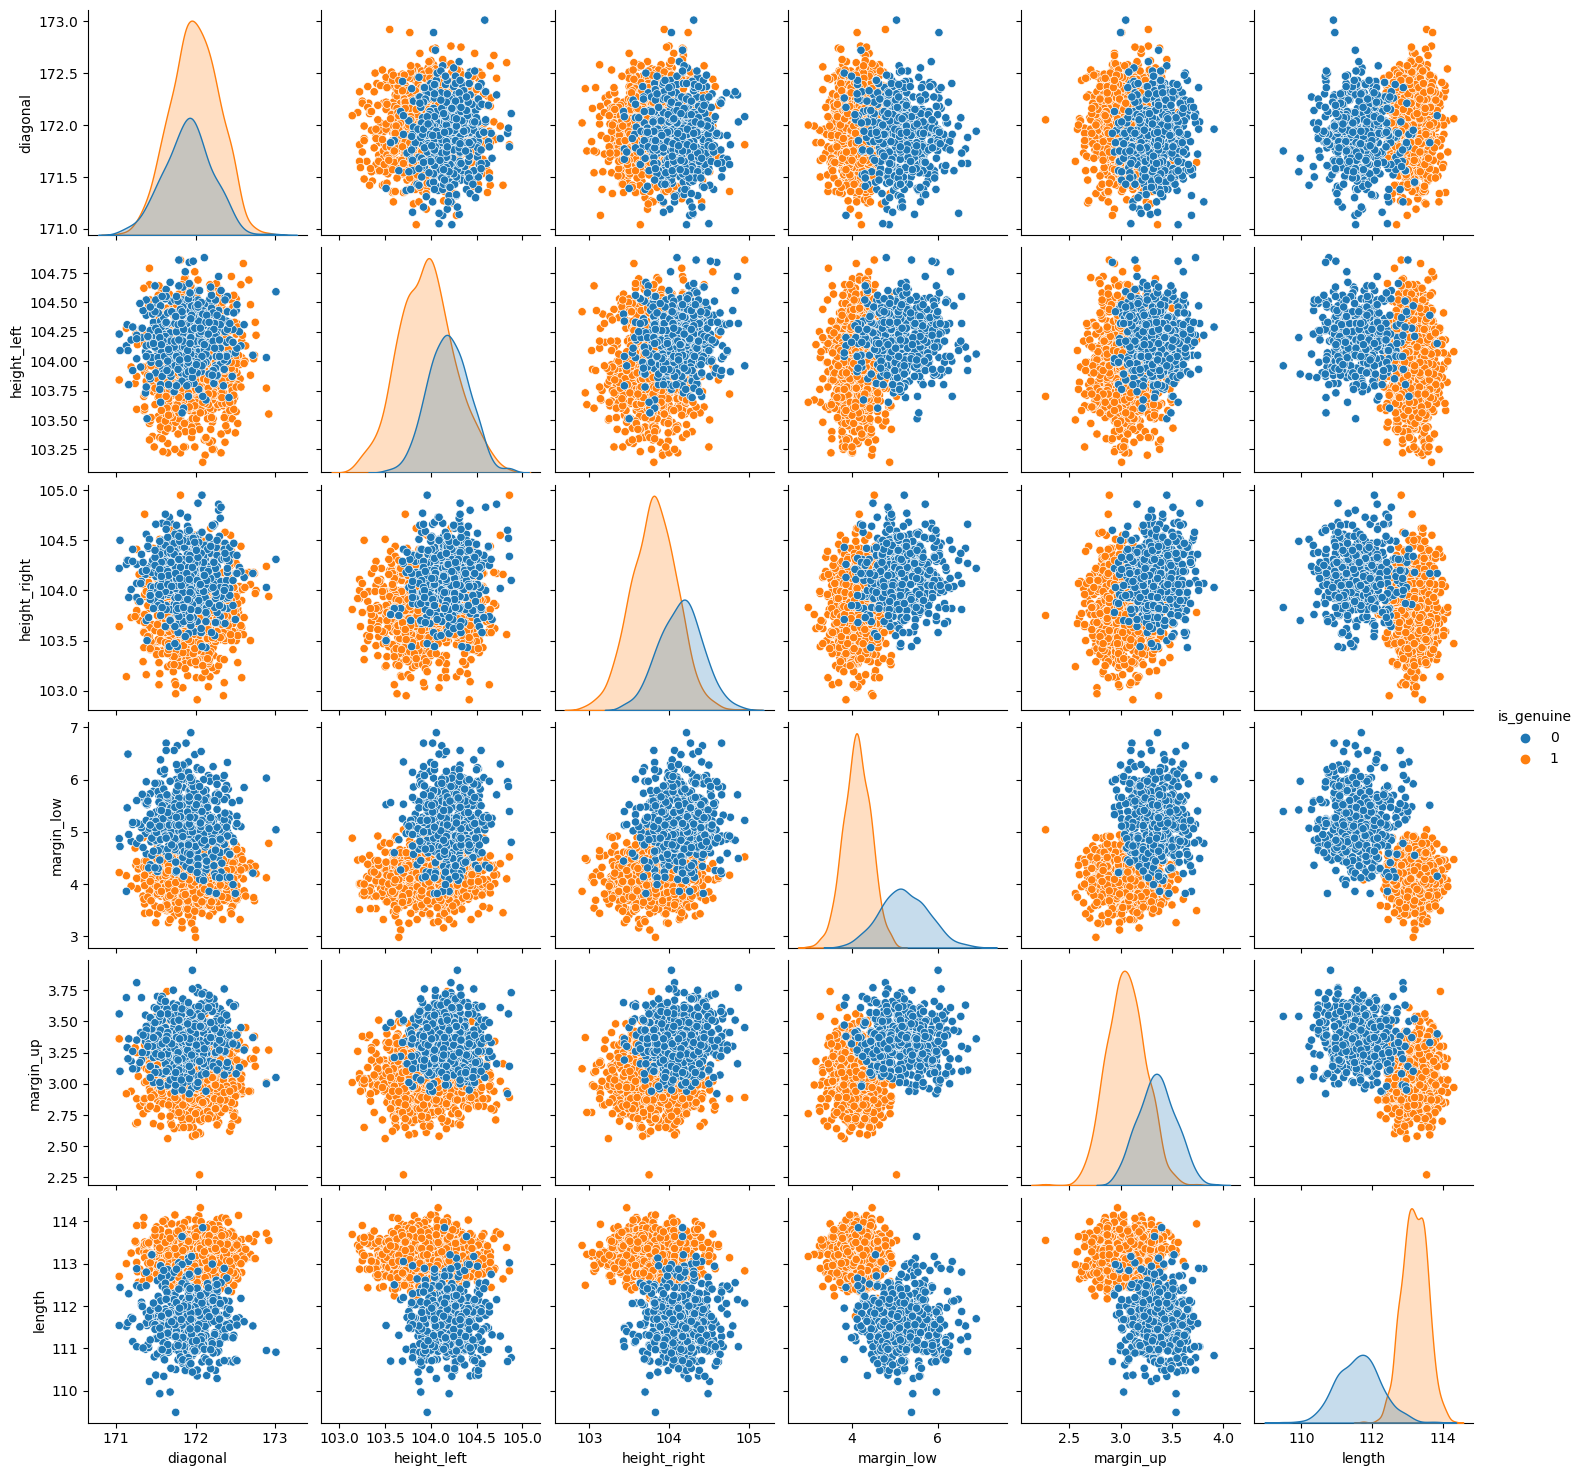

In [25]:
# Pour finir de démontrer l'intérêt de is_genuine, on peut graphiquement vérifier que margin_low dépend de is_genuine:

sns.pairplot(df_nonull, hue='is_genuine')

# 3. Vérification des conditions pour valider le modèle de régression linéaire:

## 3.1 Vérifier la colinéarité des variables:

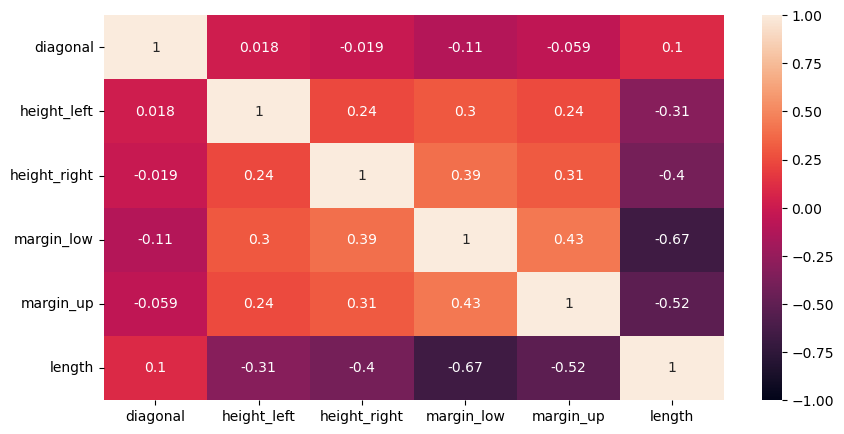

In [26]:
plt.figure(figsize=(10,5))
sns.heatmap(df_nonull[['diagonal','height_left','height_right', 'margin_low','margin_up','length']].corr(),vmin=-1,annot= True)
plt.show()

# A priori les variables n'ont pas l'air corrélées entre elles.

In [27]:
# l'estimateur des MCO existe uniquement si toutes les variables sont non co-linéaires entre elles

variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

# Ici, tous les coefficients sont inférieurs à 10 (ou 5), il n'y a donc pas de problème de colinéarité entre les variables.

[2.016930041991599, 1.1677552361727663, 1.317064799860814, 1.5948609285174227]

## 3.2 Testez la normalité des résidus

In [28]:
# Le test de Shapiro permet de contrôler l'hypothèse nulle d'une répartition normale.
    # Si p-value > 0.05 alors les résidus suivent la loi Normale.

shapiro(reg_multi.resid)

# Ici, l'hypothèse de normalité est remise en cause (car notre p-value < 0.05).

ShapiroResult(statistic=0.9936099648475647, pvalue=6.044725068932166e-06)

In [29]:
# Toutefois en vérifiant la distribution des résidus à l'aide d'un histogramme
    #on constate qu'on se rapproche grandement d'une gaussienne:

df_nonull['residual'] = (reg_multi.resid)

C:\Users\leuriot\AppData\Local\Temp\ipykernel_9680\141836010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonull['residual'] = (reg_multi.resid)


In [30]:
px.histogram(reg_multi.resid)

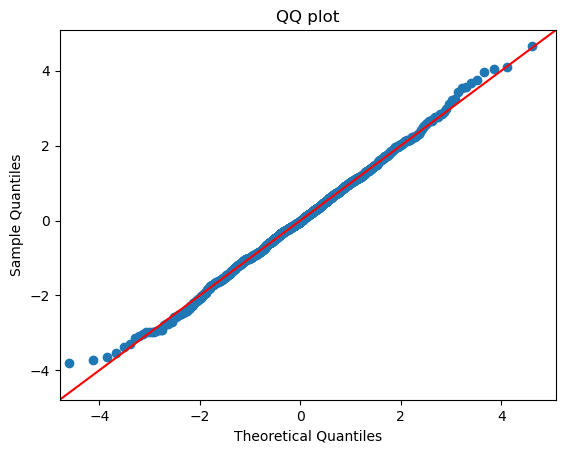

In [31]:
# On peut aussi tracer un diagramme Quantile-Quantile ou QQ plot :

fig = sm.qqplot(reg_multi.resid, stats.t, fit=True,line='45')

plt.title("QQ plot")

plt.show()

# On voit que la majorité de nos points (=nos résidus) passent sur la droite qui représente la distribution normale,
    # on peut donc considérer que nos résidus suivent une loi normale.

## 3.3 Testez l’homoscédasticité

In [32]:
# On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

# Si la p-value n'est pas inférieure à 5%, on ne rejette pas l'hypothèse 𝐻0 selon laquelle les variances sont constantes
    #(l'hypothèse d’homoscédasticité).
    
    # Ici la pvalue est <5% on peut rejetter l'hypothèses HO selon laquelle les variances sont constantes, donc nos variances
    # de résidus ne sont pas constantes

p value test Breusch Pagan: 1.8895690890744219e-34


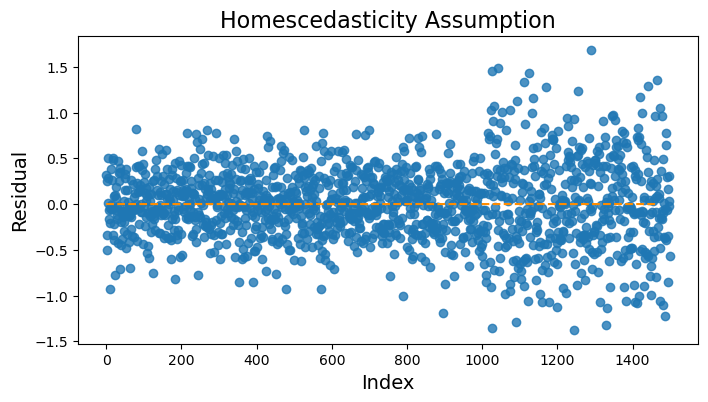

In [33]:
# Plotting the residuals
plt.subplots(figsize=(8, 4))
plt.scatter(x=df_nonull.index, y=df_nonull['residual'], alpha=0.8)
plt.plot(np.repeat(0, len(df_nonull.index)+2), color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.title('Homescedasticity Assumption', fontsize=16)
plt.show()

# Les variances des résidus sont constantes "par partie" on distingue une constance dans 1000 billets qui représentent les Vrais 
    # billets et une constance dans 500 autres billets (qui représentent les faux billets). 
    # Donc on peut considérer que nos variances sont constantes malgré le résultat du test.
    # Le résultat du test peut donc être expliqué par le fait que les vrais et les faux billets ne sont pas séparés.

# 4. Mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets: 

## 4.1 Préparations

In [34]:
# On peut remplacer les valeurs manquantes par nos prédictions dans le df 'billets' :

In [35]:
billets.loc[billets.margin_low.isna(), 'margin_low'] = reg_multi.predict(df)

In [36]:
billets.iloc[72]

is_genuine          True
diagonal          171.94
height_left       103.89
height_right      103.45
margin_low      4.062968
margin_up           3.25
length            112.79
Name: 72, dtype: object

In [37]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [38]:
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [39]:
# On renomme la colonne "is_genuine" (notre cible) = Target

billets = billets.rename(columns={'is_genuine' : 'target'})

In [40]:
billets.head()

target  diagonal  height_left  height_right  margin_low  margin_up  length
0    True    171.81       104.86        104.95        4.52       2.89  112.83
1    True    171.46       103.36        103.66        3.77       2.99  113.09
2    True    172.69       104.48        103.50        4.40       2.94  113.16
3    True    171.36       103.91        103.94        3.62       3.01  113.51
4    True    171.73       104.28        103.46        4.04       3.48  112.54

In [41]:
# On remplace True = 1 et Faux = 0

billets['target'] = billets['target'].replace([True], 1)

In [42]:
billets['target'] = billets['target'].replace([False], 0)

In [43]:
billets.head()

target  diagonal  height_left  height_right  margin_low  margin_up  length
0       1    171.81       104.86        104.95        4.52       2.89  112.83
1       1    171.46       103.36        103.66        3.77       2.99  113.09
2       1    172.69       104.48        103.50        4.40       2.94  113.16
3       1    171.36       103.91        103.94        3.62       3.01  113.51
4       1    171.73       104.28        103.46        4.04       3.48  112.54

In [44]:
# On split le df en deux avec d'un côté notre cible (y) et de l'autre le reste des données (X)

X = billets.drop(columns = 'target')
y = billets.target

In [45]:
X.head(1)

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83

In [46]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [47]:
# On créé des dataset et on fait passer les données X, y dans la fonction 'train_test_split'.
# Les "train" seront donnés à titre d'entrainement au modèle.

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=42)

# test size = on spécifie le % de données que nous voulons par rapport au train
# ici 30% des données vont dans le test et 70% dans le train
# On pourrait fixer cette valeur a 0.20, 0.25, 0.33 ...
# random state = la fonction s'execute tjs de la meme façon, et fait toujours le meme split

In [48]:
# On vérifie la forme des dataset:
    # Il y a bien 30% dans le test et 70% dans le train

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1050, 6)
(1050,)
(450, 6)
(450,)


In [49]:
# Je vérifie que dans mon y_train j'ai bien des Vrais et des Faux billets, représentés dans les bonnes proportions:

y_train.describe()

# on sait que dans notre datafram de base on a 2/3 de vrais billets (1000) et 1/3 de faux (500), 
    #que les vrais billets sont = 1 et les faux a 0,
    #donc on doit avoir une moyenne autour de 0.66 si les faux et les vrais billets sont bien représentés.

count    1050.000000
mean        0.677143
std         0.467791
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [50]:
y_test.describe()

count    450.000000
mean       0.642222
std        0.479880
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

## 4.2 Première méthode "LogistiqueRegression" : 

In [51]:
# la regression logistique modélise y ('target') en fonctions de (p) variables explicatives (= X dans notre exemple)
# On veut connaitre la probabilité d'avoir un vrai billets (y) en connaissant les (p) variables

In [52]:
# On instancie un estimateur (c'est à dire qu'on créé un "objet" = le "model", qu'on appelle ici "estimator") : 
# on fait un algorithme de régression logistique
# on entraine avec fit

estimator = LogisticRegression()
estimator.fit(X_train, y_train)

LogisticRegression()

In [53]:
#On fait une prédiction de tous les y

y_pred = estimator.predict(X_test)
y_pred

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,

In [54]:
# l'estimateur (logisticregression) peut ns permettre d'evaluer la probabilité d'appartenance à telle ou telle classe à l'aide 
    # de 'predict_proba'

y_prob = estimator.predict_proba(X_test).round(2)
y_prob

# le resultat donne une matrice, qui comporte deux colonnes, et pr chaque colonne, cest la probabilité (ou la confiance du 
    #modele) que tel individu appartienne a telle ou telle classe.
# ex: pour l'individu 1 : la probabilité est de 100% d'appartenir a la classe 0 et de 0% d'appartenir a la classe 1 
    #(cela se confirme si on regarde la case au dessus: on a bien 0 pr la 1ere valeur et 1 pr la 2ème).

array([[1.  , 0.  ],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.98, 0.02],
       [0.  , 1.  ],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.98, 0.02],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.96, 0.04],
       [0.16, 0.84],
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.5 , 0.5 ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.59, 0.41],
       [0.99, 0.01],
       [0.05, 0.95],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.01, 0.99],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.98, 0.02],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.98, 0.02],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.01,

In [55]:
# la fonction score : 

def score(estimator):
    """compute and print train score and test score"""
    
    tr_score = estimator.score(X_train, y_train).round(4)
    te_score = estimator.score(X_test, y_test).round(4)
    
    print(f'score train: {tr_score} score test: {te_score}')
    
# le "score" que l'on utilise ici est le score de base de l'estimateur LogisticRegression
# ce score est particulier, appelé "accuracy score" il est = au nombre de bonnes prédictions que nous faisons par rapport à 
    # l'ensemble des prédictions.

In [56]:
# la fonction confusion

def confusion(y_test, y_pred):
    """display a fancy confusion matrix"""
    
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    
    return mat

In [57]:
# on appelle la fonction score et confusion
# on affiche la matrice de confusion pour laquelle on a les "vrais" y de nos données "test" (en ligne) 
    #et les y prédis par notre model (en colonnes)
score(estimator)
confusion(y_test, y_pred)

# L'accuracy score est de 98.6% (on prédit 98.6 fois la bonne réponses dans l'ensemble de nos prédictions)
# (autrement dit dans notre exemple il y a 288 vrais positifs + 156 vrais négatifs / 450 prédictions)

# dans la matrice de confusion: 5 valeurs etaient à 0 et nous les avons prédites à 1
# 1 valeur etait à 1 et nous l'avons prédites à 0

# rappel : Vrai = 1 et Faux = 0

score train: 0.9914 score test: 0.9867


pred_0  pred_1
test_0     156       5
test_1       1     288

In [58]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate).round(2)
print(false_positive_rate, true_positive_rate, thresholds)
print(roc_auc)

# 'Roc auc' correspond à l'air sous la courbe
# La courbe ROC (Receiver Operating Characteristic) représente la capacité à détecter les vrais des faux billets.
# L'aire sous la courbe ROC, l' AUC (Area Under the ROC), est une mesure de la qualité qui peut être interprétée comme la
    #probabilité que, parmi deux billets choisis au hasard, un vrai et un faux, la valeur du marqueur soit plus élevée pour le 
    #vrai billet que pour le faux.  
    # l'AUC varie entre : AUC=1/2 : dans le pire des cas ; AUC=1 : dans le meilleur des cas.

[0.        0.0310559 1.       ] [0.         0.99653979 1.        ] [2 1 0]
0.98


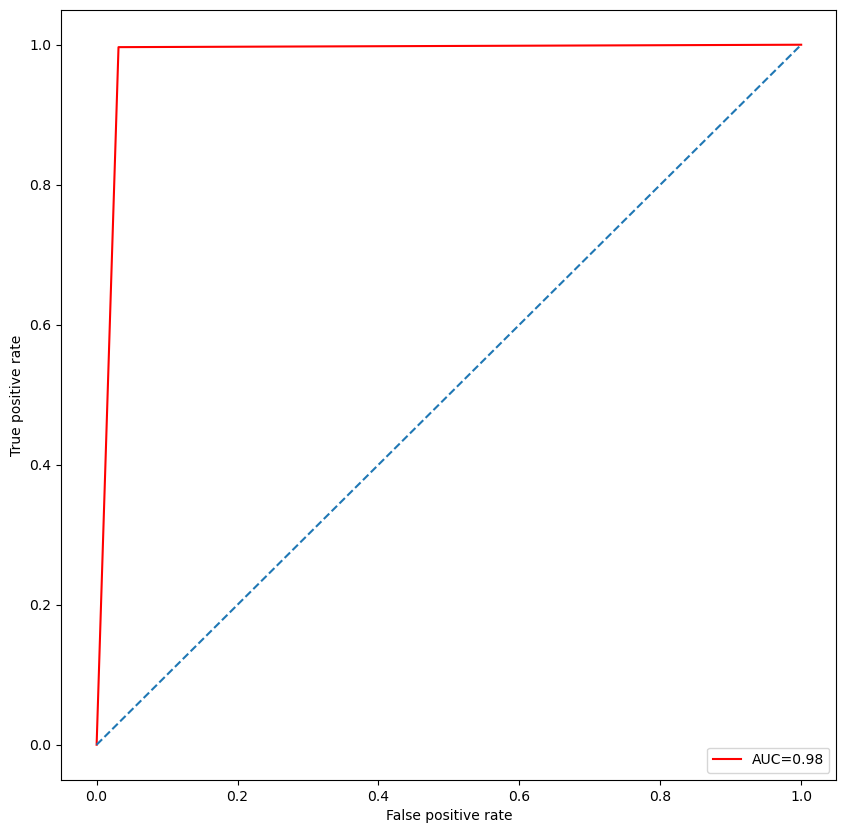

In [59]:
# La courbe ROC

plt.figure(figsize=(10,10))
plt.plot(false_positive_rate, true_positive_rate, color='red', label='AUC=%0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], linestyle='--')
plt.axis('tight')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# En ordonnée on a le taux de vrais positifs
# En abscises le taux de faux positifs

## 4.3 Deuxième Méthode: Knn + GridSearchCV

In [60]:
# On désire utiliser un autre algorithme: Nearest neighbors, mais ce dernier à plusieurs paramètres.
# Afin d'être certain de choisir les meilleurs paramètres qui vont nous conduire aux meilleurs résultats, on peut faire 
    #GridSearchCV.
# GridSearchCV va tester toutes les combinaisons de paramèrtres possibles. Il nous permet de trouver le modèle avec les 
    # meilleurs hyperparamètres, en comparant les différentes performances de chaque combinaisons grace à la technique de 
    # cross validation: On créé un "validation_set" en plus des train_set et test_set de manière à parametrer le "train_set"
    # sur le validation_set sans jamais toucher au test_set. Il y a différents types de cross validation, l'idée de base est
    # de split en plusieurs le 'train set' (par exemple split en 4, entrainer sur 3 des splits, et tester sur le dernier, etc)
# On créé un 'dictionnaire' ('n_neighbors') qui contient les différents hyperparamètres à régler ('metric'), ainsi que 
    # chaque valeur à tester (np.arange(1,20)) pour ces hyperparamètres (autrement dit dans notre exemple on demande de tester
    # des valeurs de "voisins" ('n_neighbors') de 1 à 20)
# Ensuite on fait passer notre type de modèle (Knn) dans la fonction GridSearchCV, ainsi que le dictionnaire que l'on vient
    # de créer et on spécifie notre crossvalidation (cv) : ici on demande un type StratifiedKFold qui nous permet d'être 
    # sur que lorsque l'on split nos données on aura bien des 'faux' et des 'vrais' billets dans chaque split.
# On entraine la grille sur nos données (train)

param_grid = {'n_neighbors': np.arange(1,20),
             'metric' : ['euclidean', 'manhattan']}

cv = StratifiedKFold(4)

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv)

grid.fit(X_train, y_train)

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [61]:
# On voit ici que le model qui a obtenu le meilleur score lors de l'entrainement à un score de 99%:

grid.best_score_

# rappel: l'accuracy score est = au nombre de bonnes prédictions que nous faisons par rapport à l'ensemble des prédictions

0.9923809247380491

In [62]:
# On peut voir les meilleurs paramètres de ce model:

grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 8}

In [63]:
# On sauvegarde ce model

model = grid.best_estimator_

In [64]:
# On le test sur nos données test:

model.score(X_test, y_test)

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



0.9888888888888889

In [65]:
# On fait une matrice de confusion

mat = confusion_matrix(y_test, model.predict(X_test))
mat

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[157,   4],
       [  1, 288]], dtype=int64)

In [66]:
mat = pd.DataFrame(mat)
mat

# rappel : Vrai = 1 et Faux = 0

0    1
0  157    4
1    1  288

## 4.4 Troisème méthode: kmeans

In [67]:
billets.head()

target  diagonal  height_left  height_right  margin_low  margin_up  length
0       1    171.81       104.86        104.95        4.52       2.89  112.83
1       1    171.46       103.36        103.66        3.77       2.99  113.09
2       1    172.69       104.48        103.50        4.40       2.94  113.16
3       1    171.36       103.91        103.94        3.62       3.01  113.51
4       1    171.73       104.28        103.46        4.04       3.48  112.54

In [68]:
X.head()

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83
1    171.46       103.36        103.66        3.77       2.99  113.09
2    172.69       104.48        103.50        4.40       2.94  113.16
3    171.36       103.91        103.94        3.62       3.01  113.51
4    171.73       104.28        103.46        4.04       3.48  112.54

In [69]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [70]:
# On instancie notre estimateur:

kmeans = KMeans(n_clusters=2, random_state=5)

In [71]:
# On l'entraine :

kmeans.fit(X_train)

KMeans(n_clusters=2, random_state=5)

In [72]:
# Les clusters obtenus:

clusters_kmeans = kmeans.labels_

In [73]:
clusters_kmeans

array([1, 1, 1, ..., 1, 0, 0])

In [74]:
# On ajoute les clusters au df X_train:

X_train["clusters_kmeans"] = clusters_kmeans
X_train

diagonal  height_left  height_right  margin_low  margin_up  length  \
485     171.83       104.29        103.58    4.000000       3.32  113.21   
527     171.92       103.79        103.34    3.840000       2.80  113.00   
199     171.90       104.42        104.02    4.380000       3.10  112.87   
889     172.31       103.94        103.89    4.000000       3.20  113.80   
844     171.62       104.14        104.49    4.152238       2.99  113.35   
...        ...          ...           ...         ...        ...     ...   
1130    171.56       104.29        104.19    5.230000       3.63  112.94   
1294    172.40       104.27        104.18    4.920000       3.17  111.79   
860     171.38       103.83        103.99    4.440000       3.12  113.48   
1459    171.78       104.31        103.82    6.190000       3.25  111.14   
1126    171.84       104.06        104.10    4.870000       3.25  111.04   

      clusters_kmeans  
485                 1  
527                 1  
199                 1  
889                 1  
844                 1  
...               ...  
1130                1  
1294                0  
860                 1  
1459                0  
1126                0  

[1050 rows x 7 columns]

In [75]:
X_train.groupby('clusters_kmeans').mean()

# On sait que plus les valeurs de margin_low sont hautes plus on est dans la distribution des faux billets
# et à l'inverse plus la varaible "length" est basse plus on est dans la distribution des faux billets
# donc à priori le kmeans a bien considéré que le cluster 0 = faux billets
# et que le cluster 1 = vrais billets.

diagonal  height_left  height_right  margin_low  margin_up  \
clusters_kmeans                                                                 
0                171.897034   104.198073    104.152416    5.246350   3.348899   
1                171.979876   103.951203    103.814467    4.127161   3.057137   

                     length  
clusters_kmeans              
0                111.574465  
1                113.205228

In [76]:
#On fait une prédiction de tous les y

y_pred = kmeans.predict(X_test)
y_pred

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,

In [77]:
mat1 = confusion_matrix(y_test, kmeans.predict(X_test))
mat1

array([[153,   8],
       [  0, 289]], dtype=int64)

In [78]:
mat1 = pd.DataFrame(mat1)
mat1

# rappel : Vrai = 1 et Faux = 0

0    1
0  153    8
1    0  289

## 4.5 Conclusion sur les 3 méthodes:

# 5. Tester le fichier "billets"

## 5.1 Avec la méthode Kmeans

In [79]:
test = pd.read_csv('billets_production.csv')

In [80]:
test

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

In [81]:
ID = test.id
ID

0    A_1
1    A_2
2    A_3
3    A_4
4    A_5
Name: id, dtype: object

In [82]:
ID.reset_index()

index   id
0      0  A_1
1      1  A_2
2      2  A_3
3      3  A_4
4      4  A_5

In [83]:
test.drop(columns = "id", axis =1, inplace = True)

In [84]:
test

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.76       104.01        103.54        5.21       3.30  111.42
1    171.87       104.17        104.13        6.00       3.31  112.09
2    172.00       104.58        104.29        4.99       3.39  111.57
3    172.49       104.55        104.34        4.44       3.03  113.20
4    171.65       103.63        103.56        3.77       3.16  113.33

In [85]:
y_pred = kmeans.predict(test)
y_pred

array([0, 0, 0, 1, 1])

In [86]:
pred = pd.DataFrame(y_pred)

In [87]:
pred = pred.rename(columns={0: "prédiction"})

In [88]:
pred.reset_index()

index  prédiction
0      0           0
1      1           0
2      2           0
3      3           1
4      4           1

In [89]:
pred['prédiction'].replace([0, 1],['faux', 'vrai'], inplace = True)

In [90]:
pd.merge(ID, pred, left_index=True, right_index=True)

id prédiction
0  A_1       faux
1  A_2       faux
2  A_3       faux
3  A_4       vrai
4  A_5       vrai

## 5.2 Avec la régression logistique

In [91]:
y_pred = estimator.predict(test)
y_pred

array([0, 0, 0, 1, 1], dtype=int64)

In [92]:
y_prob = estimator.predict_proba(test).round(2)
y_prob

array([[0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.09, 0.91],
       [0.  , 1.  ]])

In [93]:
pred_2 = pd.DataFrame(y_pred)

In [94]:
pred_2 = pred_2.rename(columns={0: "prédiction"})

In [95]:
pred_2.reset_index()

index  prédiction
0      0           0
1      1           0
2      2           0
3      3           1
4      4           1

In [96]:
pred_2['prédiction'].replace([0, 1],['faux', 'vrai'], inplace = True)

In [97]:
pd.merge(ID, pred_2, left_index=True, right_index=True)

id prédiction
0  A_1       faux
1  A_2       faux
2  A_3       faux
3  A_4       vrai
4  A_5       vrai

## 5.3 Avec le Knn

In [98]:
y_pred = model.predict(test)
y_pred

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([0, 0, 0, 1, 1], dtype=int64)

In [99]:
pred_3 = pd.DataFrame(y_pred)

In [100]:
pred_3 = pred_3.rename(columns={0: "prédiction"})

In [101]:
pred_3.reset_index()

index  prédiction
0      0           0
1      1           0
2      2           0
3      3           1
4      4           1

In [102]:
pred_3['prédiction'].replace([0, 1],['faux', 'vrai'], inplace = True)

In [103]:
pd.merge(ID, pred_3, left_index=True, right_index=True)

id prédiction
0  A_1       faux
1  A_2       faux
2  A_3       faux
3  A_4       vrai
4  A_5       vrai

# Test en Live pour la soutenance:

In [117]:
live = pd.read_csv('billets_test.csv')

In [118]:
live

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5

In [119]:
ID_1 = live.id
ID_1

0    B_1
1    B_2
2    B_3
3    B_4
4    B_5
Name: id, dtype: object

In [120]:
ID_1.reset_index()

index   id
0      0  B_1
1      1  B_2
2      2  B_3
3      3  B_4
4      4  B_5

In [121]:
live.drop(columns = "id", axis =1, inplace = True)

In [122]:
live

diagonal  height_left  height_right  margin_low  margin_up  length
0    172.09       103.95        103.73        4.39       3.09  113.19
1    171.52       104.17        104.03        5.27       3.16  111.82
2    171.78       103.80        103.75        3.81       3.24  113.39
3    172.02       104.08        103.99        5.57       3.30  111.10
4    171.79       104.34        104.37        5.00       3.07  111.87

In [123]:
y_pred = estimator.predict(live)
y_pred

array([1, 0, 1, 0, 0], dtype=int64)

In [124]:
pred_4 = pd.DataFrame(y_pred)

In [126]:
pred_4 = pred_4.rename(columns={0: "prédiction"})

In [127]:
pred_4.reset_index()

index  prédiction
0      0           1
1      1           0
2      2           1
3      3           0
4      4           0

In [128]:
pred_4['prédiction'].replace([0, 1],['faux', 'vrai'], inplace = True)

In [129]:
pd.merge(ID_1, pred_4, left_index=True, right_index=True)

id prédiction
0  B_1       vrai
1  B_2       faux
2  B_3       vrai
3  B_4       faux
4  B_5       faux